<a href="https://colab.research.google.com/github/Shanu-Mathew/Tensorflow-Notes/blob/main/Transfer_Learning_with_Tensorflow_(Feature_Extraction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 1: Feature Extraction
Transfer learning (TL) is a technique in machine learning (ML) in which knowledge learned from a task is re-used in order to boost performance on a related task.

Benefits:-
1. It can leverage an existing neural network architecture proven to work on problems similar to our own.
2. It can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our data.

In [ ]:
!nvidia-smi

Wed Sep 20 13:17:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |   4901MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf

## Data Ingestion

In [ ]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-09-20 13:17:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M  22.4MB/s    in 8.3s    

2023-09-20 13:17:31 (19.4 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

There are 2 directories and 0 images in '10_food_classes_10_percent
There are 10 directories and 0 images in '10_food_classes_10_percent/test
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi
There are 

## Preparing the data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE=(224,224)
BATCH_SIZE=32


train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print("Training Images:")

train_data=train_datagen.flow_from_directory(train_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")
print("Testing Image:")

test_data=test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training Images:
Found 750 images belonging to 10 classes.
Testing Image:
Found 2500 images belonging to 10 classes.


## Setting up Callbacks

Some of the most popular callbacks are:
1. Experiments Tracking with the Tensorboard callback
2. Model checkpoint with the ModelCheckpoint callback
3. Stopping a model from training with the EarlyStopping Callback

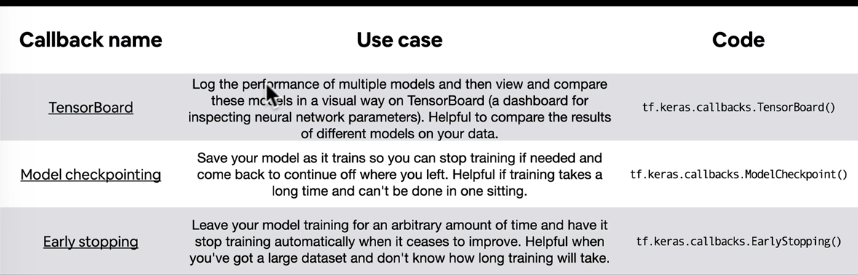

### TensorBoard

In [ ]:
# Create Tensorboard Callback
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name+'/'+experiment_name+'/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log file to:{log_dir}')
  return tensorboard_callback

## Creating models using Tensorflow Hub
We can access pre-trained models in :[https://tfhub.dev/](https://tfhub.dev/)

In [ ]:
efficient_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url,num_classes=10):
  """
  Takes a Tensorflow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url(str): A TensorFlow Hub feature extraction URL
    num_classes(int): Number of output neurons in the output layer

  Returns:
  An uncompiled Keras Sequential Model with model_url as feature extractor layer and Dense output layer
  with num_classes as output neurons.
  """
  #Download the pretrained model and save it as a Keras Layer
  feature_extractor_layer=hub.KerasLayer(model_url,
                                        trainable=False,
                                        name="feature_extraction_layer",
                                        input_shape=IMG_SHAPE+(3,))
  #Create Model
  model=tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])
  return model

### Create Resnet Model

In [ ]:
# Create Model
resnet_model=create_model(resnet_url,num_classes=train_data.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
resnet_history=resnet_model.fit(train_data,
                 epochs=5,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="Tensorflow_hub",
                                                        experiment_name="resnet50v2")])

Saving TensorBoard log file to:Tensorflow_hub/resnet50v2/20230920-131738
Epoch 1/5
24/24 [==============================] - 21s 500ms/step - loss: 1.9386 - accuracy: 0.3693 - val_loss: 1.1756 - val_accuracy: 0.6328
Epoch 2/5
24/24 [==============================] - 11s 472ms/step - loss: 0.9060 - accuracy: 0.7227 - val_loss: 0.8429 - val_accuracy: 0.7384
Epoch 3/5
24/24 [==============================] - 11s 457ms/step - loss: 0.6194 - accuracy: 0.8360 - val_loss: 0.7618 - val_accuracy: 0.7544
Epoch 4/5
24/24 [==============================] - 13s 545ms/step - loss: 0.4841 - accuracy: 0.8733 - val_loss: 0.7063 - val_accuracy: 0.7704
Epoch 5/5
24/24 [==============================] - 13s 541ms/step - loss: 0.3820 - accuracy: 0.9173 - val_loss: 0.6668 - val_accuracy: 0.7860


In [ ]:
# Function to plot our loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics

  Args:
    history: Tensorflow History Object

  Returns:
    Plots of training/validation loss and accuracy metrics
  """

  loss= history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs,loss,label="loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

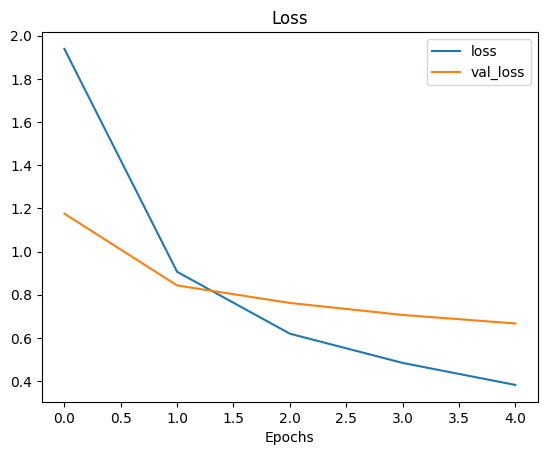

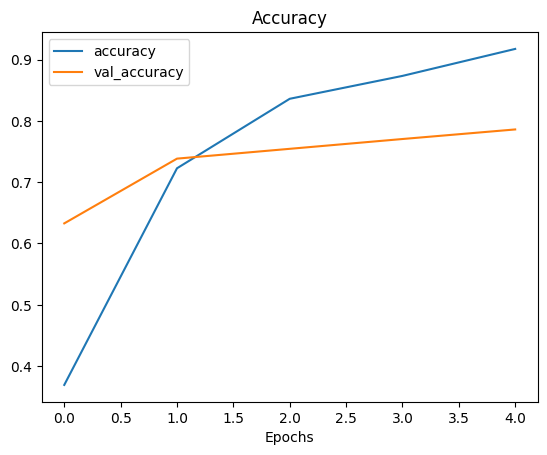

In [ ]:
plot_loss_curves(resnet_history)

### Create Efficient Net Model

In [ ]:
efficientnet_model=create_model(efficient_url,num_classes=train_data.num_classes)

In [ ]:
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
efficientnet_history=efficientnet_model.fit(train_data,
                 epochs=5,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="Tensorflow_hub",
                                                        experiment_name="efficientnetb0")])

Saving TensorBoard log file to:Tensorflow_hub/efficientnetb0/20230920-131914
Epoch 1/5
24/24 [==============================] - 21s 495ms/step - loss: 1.8110 - accuracy: 0.4680 - val_loss: 1.2656 - val_accuracy: 0.7400
Epoch 2/5
24/24 [==============================] - 23s 981ms/step - loss: 1.0444 - accuracy: 0.7840 - val_loss: 0.8529 - val_accuracy: 0.8292
Epoch 3/5
24/24 [==============================] - 12s 536ms/step - loss: 0.7493 - accuracy: 0.8520 - val_loss: 0.6936 - val_accuracy: 0.8504
Epoch 4/5
24/24 [==============================] - 13s 542ms/step - loss: 0.6036 - accuracy: 0.8693 - val_loss: 0.6056 - val_accuracy: 0.8580
Epoch 5/5
24/24 [==============================] - 10s 449ms/step - loss: 0.5094 - accuracy: 0.8947 - val_loss: 0.5566 - val_accuracy: 0.8600


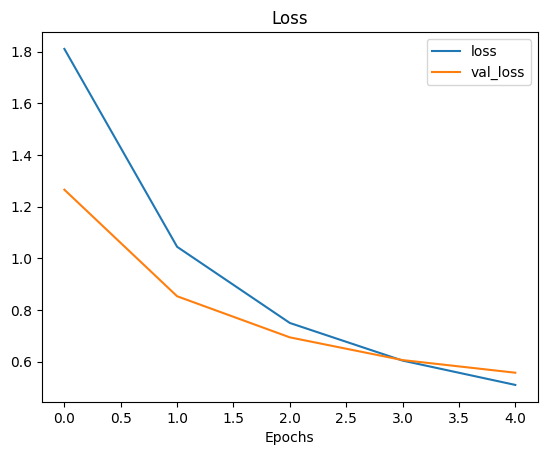

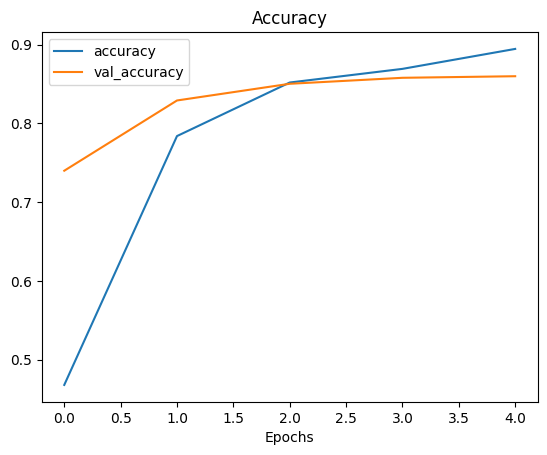

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


## Different types of transfer learning

* "As is" transfer learning - using an existing model with no changes whatsoever (e.g. using ImageNet Model on 1000 ImageNet Classes)

* "Feature Extraction" - Use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem.

* "Fine-Tuning" transfer learning - Use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers. (including new output layer)











In [ ]:
# Upload tensorboard dev records
!tensorboard dev upload --logdir ./Tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2"\
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of training data" \
  --one_shot

2023-09-20 13:28:08.192429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/lZtrWhm4TrCWtrVGZDAq5Q/

[2023-09-20T13:28:10] Started scanning logdir.
[2023-09-20T13:28:23] Total uploaded: 180 scalars, 0 tensors, 6 binary objects (15.9 MB)
[2023-09-20T13:28:23] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/lZtrWhm4TrCWtrVGZDAq5Q/


https://tensorboard.dev/experiment/lZtrWhm4TrCWtrVGZDAq5Q/

In [ ]:
!tensorboard dev list

2023-09-20 13:34:36.304904: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/lZtrWhm4TrCWtrVGZDAq5Q/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of training data
	Id                   lZtrWhm4TrCWtrVGZDAq5Q
	Created              2023-09-20 13:28:10 (6 minutes ago)
	Updated              2023-09-20 13:28:23 (6 minutes ago)
	Runs                 12
	Tags                 7
	Scalars              180
	Tensor bytes         0
	Binary object bytes  16643733
Total: 1 experiment(s)


In [ ]:
#Delete an experiment
# !tensorboard dev delete --experiment_id lZtrWhm4TrCWtrVGZDAq5Q

2023-09-20 13:35:23.422178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard dev delete
       [-h]
       [--helpfull]
       [--experiment_id EXPERIMENT_ID]
tensorboard dev delete: error: argument --experiment_id: expected one argument
